In [1]:
import json
import itertools
import cPickle

from collections import Counter, defaultdict

import pandas as pd
import numpy as np
from tqdm import tqdm
import feather

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_res = feather.read_dataframe('./stacking_pred.feather')

Markov clustering params

In [3]:
T = 100
p = 0.8
EXPANSION_POWER = 2
INFLATION_POWER = 2.2

Top results

In [4]:
best_res = []
seen = set()
count = 215307 * 0.4

for _, row in tqdm(df_res.iterrows()):
    uid1 = int(row.user_1)
    uid2 = int(row.user_2)
    score = row.model_score

    if (uid1, uid2) in seen or (uid2, uid1) in seen:
        continue

    seen.add((uid1, uid2))
    best_res.append((uid1, uid2, score))

    count = count - 1
    if count <= 0:
        break

155341it [00:09, 16727.72it/s]


In [5]:
best_res[-1]

(18721, 57242, 0.63561976)

Collecting data for MCL

In [6]:
def get_component_nodes(other_nodes, uid):
    nodes = other_nodes[uid]
    if len(nodes) == 0:
        nodes.add(uid)
    return nodes

def merge_components(other_nodes, uid1, uid2):
    nodes = other_nodes[uid1] | other_nodes[uid2]
    for node in nodes:
        other_nodes[node] = nodes

In [7]:
other_nodes = defaultdict(set)

df_markov_nodes = []
seen = set()
count = 215307
skipped = 0

for _, row in tqdm(df_res.iterrows()):
    uid1 = int(row.user_1)
    uid2 = int(row.user_2)
    score = row.model_score

    if score <= p:
        break

    if (uid1, uid2) in seen or (uid2, uid1) in seen:
        continue

    nodes_1 = get_component_nodes(other_nodes, uid1)
    nodes_2 = get_component_nodes(other_nodes, uid2)

    if len(nodes_1) + len(nodes_2) > T:
        skipped = skipped + 1
        continue 

    seen.add((uid1, uid2))
    merge_components(other_nodes, uid1, uid2)

    df_markov_nodes.append((uid1, uid2, score))

    count = count - 1
    if count <= 0:
        break

116017it [00:08, 14260.84it/s]


In [8]:
len(df_markov_nodes), skipped

(64133, 0)

In [9]:
df_markov_nodes = pd.DataFrame(df_markov_nodes, columns=['user_1', 'user_2', 'score'])
df_markov_nodes.tail()

,user_1,user_2,score
64128,8382,337011,0.800032
64129,140733,268054,0.800030
64130,118794,264913,0.800005
64131,150089,162928,0.800003
64132,112851,165087,0.800003


In [10]:
edges = zip(df_markov_nodes.user_1, df_markov_nodes.user_2)
scores = dict(zip(edges, df_markov_nodes.score))

In [11]:
def edge_score(u1, u2):
    if (u1, u2) in scores:
        return scores[(u1, u2)]
    if (u2, u1) in scores:
        return scores[(u2, u1)]
    return 0.0

In [12]:
G = nx.Graph()

for u1, u2 in tqdm(edges):
    G.add_edge(u1, u2)

100%|██████████| 64133/64133 [00:00<00:00, 154792.05it/s]


In [13]:
components = list(nx.connected_components(G))

MCL implementation:

In [14]:
def normalize_cols(M):
    return M / M.sum(axis=0, keepdims=1)

def prepare_markov_matrix(comp):
    n = len(comp)
    M = np.zeros((n, n), dtype=float)

    for i in xrange(n):
        M[i, i] = 1.0
        for j in xrange(i + 1, n):
            s = edge_score(comp[i], comp[j])
            M[i, j] = M[j, i] = s
    
    return normalize_cols(M)


def markov_step(M, n, p):
    for i in range(n):
        M = M.dot(M)
    
    M = M ** p
    return normalize_cols(M)

def array_to_graph(M):
    GM = nx.Graph()

    N, _  = M.shape
    for i in xrange(N):
        for j in xrange(i + 1, N):
            s = M[i, j]
            if s > 1e-6:
                GM.add_edge(i, j)
    return GM


def markov_clustering(comp, n, p, max_iter=100):
    comp = sorted(comp)
    M = prepare_markov_matrix(comp)

    c = max_iter
    while c > 0:
        M_old = M
        M = markov_step(M, n, p)
        err = ((M - M_old) ** 2).sum()
        if err < 1e-6:
            break

    M[M < 1e-6] = 0.0

    GM = array_to_graph(M)
    new_comps = list(nx.connected_components(GM))

    result = []
    for c in new_comps:
        result.append([comp[i] for i in c])
    
    return result

def draw_graph(M):
    GM = array_to_graph(M)
    nx.draw(GM)
    plt.show()

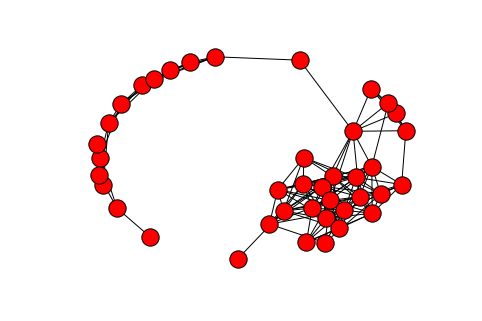

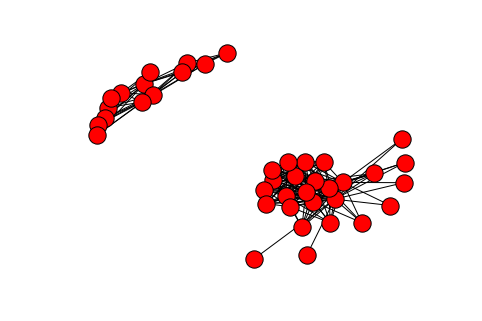

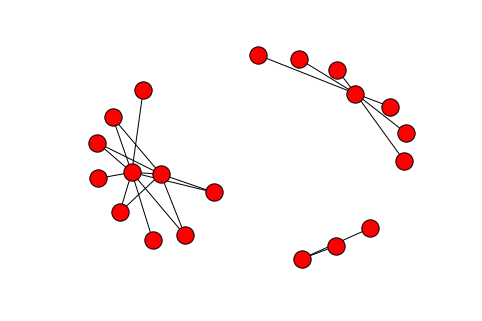

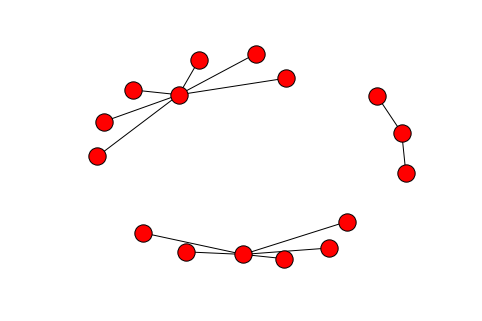

In [15]:
comp = list(components[1099])
M = prepare_markov_matrix(comp)
draw_graph(M)

M = markov_step(M, n=2, p=2.2)
M = markov_step(M, n=2, p=2.2)
M = markov_step(M, n=2, p=2.2)
M = markov_step(M, n=2, p=2.2)
draw_graph(M)

M = markov_step(M, n=2, p=2.2)
M = markov_step(M, n=2, p=2.2)
M = markov_step(M, n=2, p=2.2)
M = markov_step(M, n=2, p=2.2)
draw_graph(M)

M = markov_step(M, n=2, p=2.2)
M = markov_step(M, n=2, p=2.2)
M = markov_step(M, n=2, p=2.2)
M = markov_step(M, n=2, p=2.2)
draw_graph(M)

In [16]:
component_results = []

for comp in tqdm(components):
    if len(comp) <= 3:
        component_results.append(comp)
        continue

    new_comp = markov_clustering(comp, n=EXPANSION_POWER, p=INFLATION_POWER)
    component_results.extend(new_comp)

100%|██████████| 18201/18201 [00:01<00:00, 11366.50it/s]


In [17]:
len(component_results), len(components)

(17429, 18201)

In [18]:
pd.Series([len(c) for c in component_results]).describe()

count    17429.000000
mean         2.800907
std          1.105756
min          2.000000
25%          2.000000
50%          3.000000
75%          3.000000
max         22.000000
dtype: float64

In [19]:
pairs = []

for comp in component_results:
    if len(comp) > 6:
        continue

    for (u1, u2) in list(itertools.combinations(comp, r=2)):
        pairs.append((u1, u2))

In [20]:
len(pairs)

45471

In [21]:
with open('tmp/idx_to_uid.bin', 'rb') as f:
    idx_to_uid = cPickle.load(f)

In [22]:
seen = set()

with open('submission.txt', 'w') as f_out:
    for uid1, uid2, _ in tqdm(best_res):
        seen.add((uid1, uid2))

        uid1 = idx_to_uid[uid1]
        uid2 = idx_to_uid[uid2]
        if uid2 < uid1:
            uid2, uid1 = uid1, uid2

        f_out.write("%s,%s\n" % (uid1, uid2))
    
    for uid1, uid2 in tqdm(pairs):
        if (uid1, uid2) in seen or (uid2, uid1) in seen:
            continue

        seen.add((uid1, uid2))

        uid1 = idx_to_uid[uid1]
        uid2 = idx_to_uid[uid2]
        if uid2 < uid1:
            uid2, uid1 = uid1, uid2

        f_out.write("%s,%s\n" % (uid1, uid2))

100%|██████████| 45471/45471 [00:00<00:00, 704103.83it/s]


In [23]:
!wc -l submission.txt

92985 submission.txt


In [24]:
!zip -r submission-mc4.zip submission.txt

updating: submission.txt (deflated 44%)
